In [1]:
from unicodedata import name
import qiskit 
import numpy as np 
import matplotlib.pyplot as plt
from typing import Optional, Union, List, Callable, Tuple
import pennylane as qml 
import networkx as nx
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel
from tqdm import tqdm
import jax 
import jax.numpy as jnp
import random
import optax 

import netket as nk
from scipy.linalg import eigh, eigvalsh

/local/conda/miniconda3/envs/autobahnplus/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [13]:
# Import all the hyper-parameters

class myargs: 
    def __init__(self) -> None:
        pass 

myargs.p =2 
myargs.lr = 0.05
myargs.irrep = [2,2]
myargs.num_qubits = 4
myargs.num_yjms = 1
myargs.trotter_slice = 2
myargs.lattice_size = [2,2]
myargs.J = [1.0, 0.0]
myargs.iterations = 100
myargs.TOKEN = "4c84e8146c0def626bb384424f78598ee055148df74863d4cbad29fb99d5e9cd4808077115561b6490f6dc4a0f8014b24fe5985003cdbb88c17a51c80c55279a" 
myargs.backend = 'ibm_perth'
# myargs.device = 0

#### Check the Exact Diagonal 



In [14]:
def getHam_square(lattice_size: Union[int, list], J: Optional[Union[list, int]], get_matrix: bool=False):
    '''
    Build the Heisenberg Hamiltonian 
    '''
    graph = nx.generators.lattice.grid_2d_graph(lattice_size[0],lattice_size[1])
    graph = nx.relabel.convert_node_labels_to_integers(graph)
    obs = []
    coeffs = []
    for edge in graph.edges():
        coeffs.extend([1.0, 1.0, 1.0])
        obs.extend([qml.PauliX(edge[0]) @ qml.PauliX(edge[1]),
                            qml.PauliY(edge[0]) @ qml.PauliY(edge[1]),
                            qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])])
    hamiltonian_heisenberg = qml.Hamiltonian(coeffs, obs) * J[0]
    if get_matrix: 
        # matrix = 0
        # for coeff, op in zip(hamiltonian_heisenberg.coeffs, hamiltonian_heisenberg.ops):
        #     # print(op.matrix())
        #     matrix += coeff * np.real(op.matrix()).astype('float64')
        matrix = qml.utils.sparse_hamiltonian(hamiltonian_heisenberg).real.toarray()
        return matrix.astype('float64')
    return hamiltonian_heisenberg

ham_mat = getHam_square(myargs.lattice_size, myargs.J, get_matrix=True)
# print(ham_mat.shape)
E_gs, V_gs = eigh(ham_mat.astype('float64'), subset_by_index=[0,1])
V_gs = V_gs[:,0]
e_gs = E_gs[0]
print(f'the complete spectrum: {E_gs}')
print('True Ground state Energy via ED :--- ({}) '.format(e_gs))

the complete spectrum: [-8. -4.]
True Ground state Energy via ED :--- (-7.999999999999999) 


#### State Preparation 

In [15]:
# state preparation:

def state_init(irrep: list):

    num_bell = 2*  (irrep[0] - abs(irrep[0] - irrep[1]))
    # num_comp = abs(irrep[0] - irrep[1])
    for i in range(0, num_bell-1):
        if i %2 ==0:
            qml.Hadamard(wires=i)
            qml.CNOT(wires=[i,i+1]) 


#### The eSWAP layers consisting of even and odd adjanct transpositions

In [16]:
def _swap2pauli(i: int, j:int, mode='ham'): 
    '''
    using the formula: SWAP(i j) = Si . Sj + 1/2 I (without I ) 
    '''
    if mode=='ham':
        coeff = np.ones(3)
        hamiltonian = [qml.PauliX(wires=i) @qml.PauliX(wires=j), 
                    qml.PauliY(wires=i) @qml.PauliY(wires=j),
                    qml.PauliZ(wires=i) @qml.PauliZ(wires=j) ]
        return qml.Hamiltonian(coeff, hamiltonian)
    elif mode=='list':
        hamiltonian = [qml.PauliX(wires=i) @qml.PauliX(wires=j), 
                    qml.PauliY(wires=i) @qml.PauliY(wires=j),
                    qml.PauliZ(wires=i) @qml.PauliZ(wires=j) ]
        return hamiltonian

def coxeters(heis_params: jnp.array, layer:int, trotter_slice:int=myargs.trotter_slice): 
    '''
    if p is even, return evens 
    if p is odd, return odds
    '''
    if layer % 2 == 0: 
        for j, i  in enumerate(range(myargs.num_qubits)):
            if i % 2 ==0 & i +1 < myargs.num_qubits:
                # print(f'j, i: {j, i}')
                swap = _swap2pauli(i, i+1, mode='ham')
                qml.ApproxTimeEvolution(swap, heis_params[int(j/2)], trotter_slice)
    elif layer % 2==1:
        for j, i in enumerate(range(myargs.num_qubits)):
            if i % 2 ==1 & i +1 < myargs.num_quibts:
                swap = _swap2pauli(i, i+1, mode='ham')
                qml.ApproxTimeEvolution(swap, heis_params[int((j-1)/2)], trotter_slice)

#### Hamiltonian Ansatz 


In [17]:
def var_ham_ans(heis_param: jnp.array, trotter_slice:int=myargs.trotter_slice): 
    hamiltonian = getHam_square(myargs.lattice_size, myargs.J)
    return qml.ApproxTimeEvolution(hamiltonian,heis_param, trotter_slice )

#### Now the YJM Mixer Layer

In [18]:
def _get_YJM(idx:int):
    '''
    get YJM elements for a given index
    '''
    if idx == 0:
        print('too trivial choice')
        raise NotImplementedError
    elif idx ==1: 
        YJM = _swap2pauli(0,1, mode='ham')
        # print('---------')
        # print(YJM)
        return YJM
    else:
        swaps = []
        # yjm_lst = _swap2pauli(0, 1, mode='list')
        for i in range(idx):
            swaps.append(_swap2pauli(i, idx, mode='list'))
            # YJM += qml.SWAP(wires=[i, idx])
        # print(swaps)
        flat_yjm_lst = [item for sublist in swaps for item in sublist]
        # print(qml.Hamiltonian([1.0], [swaps[0]]))
        return qml.Hamiltonian(np.ones(len(flat_yjm_lst)), flat_yjm_lst)


def yjm_gates(yjm_params: jnp.array, trotter_slice:int=myargs.trotter_slice):
    # num_yjms = int(np.floor(num_qubits /3))
    # selection = np.random.randint(1, myargs.num_qubits, myargs.num_yjms)
    selection = random.sample(range(1, myargs.num_qubits), myargs.num_yjms)
    for i, sel in enumerate(selection):
        YJM = _get_YJM(sel)
        qml.ApproxTimeEvolution(YJM, yjm_params[i], trotter_slice)

#### Compiling the Circuits and perform measurements

In [19]:
def cqa_layers(params_dict:dict, trotter_slice:int=myargs.trotter_slice): 
    for layer in range(myargs.p):
        coxeters(params_dict['Heis'][layer], layer=layer, trotter_slice=trotter_slice)
        # var_ham_ans(params_dict['Heis'][layer,0], trotter_slice=trotter_slice)
        yjm_gates(params_dict['YJM'][layer], trotter_slice =trotter_slice)

In [20]:
def train_with_optimizer(cost_fn, optimizer: optax.GradientTransformation):
    '''
    update the gradient via jax 
    '''

    key = jax.random.PRNGKey(0)
    key1, key2 = jax.random.split(key)
    params_dict_init = {'YJM': jax.random.uniform(key1, (myargs.p, myargs.num_yjms)),
                    'Heis': jax.random.uniform(key2, (myargs.p,int(np.ceil(myargs.num_qubits/2))))}
    opt_state = optimizer.init(params_dict_init)
    loss_history, grad_history, param_history = [], [], [params_dict_init]
    # print('-------drawing the circuit--------')
    # drawer = qml.draw(cqa_circuit)
    # print(drawer(params_dict_init))
    # print(iteration)
    loss_grad_fn = jax.jit(jax.value_and_grad(cost_fn))
    for it in tqdm(range(1, myargs.iterations + 1)): 
        p_dict = param_history[-1]
        # print('p_dict | YJM: {} | Heis: {}'.format(p_dict['YJM'], p_dict['Heis']))
        loss, gradient = loss_grad_fn(p_dict)
        updates, opt_state = optimizer.update(gradient, opt_state, p_dict)
        # print(f'gradient: {gradient}')
        # print("Step {:3d}   Cost_L = {:9.7f}".format(it, loss))
        updated_p_dict = optax.apply_updates(p_dict, updates)
        # updated_p_dict = {'YJM': p_dict['YJM'] - myargs.lr * gradient['YJM'],
        #                 'Heis': p_dict['Heis'] - myargs.lr * gradient['Heis']}
        param_history.append(updated_p_dict)
        loss_history.append(loss)
        grad_history.append(gradient)
        if jnp.linalg.norm(gradient['YJM']) / gradient['YJM'].size < 1e-6:
            print(gradient['YJM'])
            print('encountering the Barren Plateau')
            break
    return loss_history, param_history, grad_history

#### Now we perform the circuit model with noise-free simulation

100%|██████████| 100/100 [00:05<00:00, 18.12it/s]


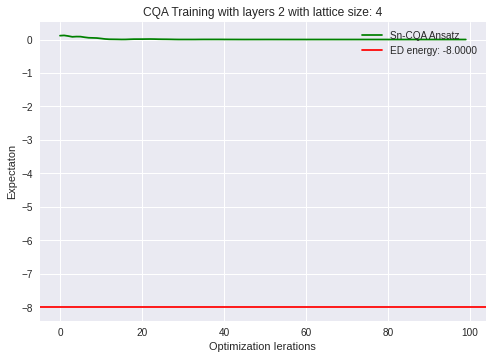

In [21]:
dev_mu = qml.device("default.qubit", wires=myargs.num_qubits)
@qml.qnode(dev_mu, interface='jax')
def cqa_circuit(params_dict: dict, check_symmetry:bool=False, trotter_slice:int=myargs.trotter_slice):
    state_init(myargs.irrep)
    cqa_layers(params_dict, trotter_slice=trotter_slice)
    # hamiltonian = getHam_square(myargs.lattice_size, myargs.J)
    if check_symmetry is False:
        hamiltonian = getHam_square(myargs.lattice_size, myargs.J) 
        return qml.expval(hamiltonian)
    else: 
        su2_pauli = qml.PauliZ(0)
        for i in range(1, myargs.num_qubits):
            su2_pauli = su2_pauli @ qml.PauliZ(i) 
        return qml.expval(su2_pauli), qml.expval(qml.Identity(wires=0)) 

optimizer = optax.adamw(learning_rate=myargs.lr)
loss_history, param_history, grad_history = train_with_optimizer(cqa_circuit, optimizer)
plt.style.use("seaborn")
plt.plot(loss_history, "g", label='Sn-CQA Ansatz')
plt.axhline(e_gs, color='r', linestyle='-', label='ED energy: {:.4f}'.format(e_gs))
plt.ylabel("Expectaton")
plt.xlabel("Optimization Ierations")
plt.legend(loc="upper right")
plt.title(f'CQA Training with layers {myargs.p} with lattice size: {myargs.num_qubits}') 
plt.show()

#### Now we perform the quantum simulation with noise

In [23]:
qiskit.IBMQ.disable_account()

/local/conda/miniconda3/envs/autobahnplus/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (166062.34176462912 > 2 * 80324.34146378473). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/local/conda/miniconda3/envs/autobahnplus/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (166062.34176462912 > 2 * 80324.34146378473). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/local/conda/miniconda3/envs/autobahnplus/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 

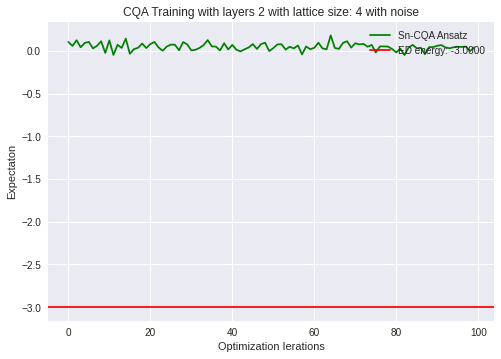

In [24]:
provider = qiskit.IBMQ.enable_account(myargs.TOKEN, hub='ibm-q-startup', group='qbraid', project='main')
backend = provider.get_backend(myargs.backend)
noise_model = NoiseModel.from_backend(backend)  
dev_mu = qml.device('qiskit.aer', wires = myargs.num_qubits, noise_model=noise_model)
# qiskit.IBMQ.disable_account()

@qml.qnode(dev_mu, interface='jax')
def cqa_circuit(params_dict: dict, check_symmetry:bool=False, trotter_slice:int=myargs.trotter_slice):
    state_init(myargs.irrep)
    cqa_layers(params_dict, trotter_slice=trotter_slice)
    # hamiltonian = getHam_square(myargs.lattice_size, myargs.J)
    if check_symmetry is False:
        hamiltonian = getHam_square(myargs.lattice_size, myargs.J) 
        return qml.expval(hamiltonian)
    else: 
        su2_pauli = qml.PauliZ(0)
        for i in range(1, myargs.num_qubits):
            su2_pauli = su2_pauli @ qml.PauliZ(i) 
        return qml.expval(su2_pauli), qml.expval(qml.Identity(wires=0)) 

optimizer = optax.adamw(learning_rate=myargs.lr)
loss_history_noise, param_history_noise, grad_history_noise = train_with_optimizer(cqa_circuit, optimizer)
plt.style.use("seaborn")
plt.plot(loss_history_noise, "g", label='Sn-CQA Ansatz')
plt.axhline(e_gs, color='r', linestyle='-', label='ED energy: {:.4f}'.format(e_gs))
plt.ylabel("Expectaton")
plt.xlabel("Optimization Ierations")
plt.legend(loc="upper right")
plt.title(f'CQA Training with layers {myargs.p} with lattice size: {myargs.num_qubits} with noise') 
plt.show()

#### Comparison with the Jax implementation 

Note that JAX implementation uses full YJMs and heiseneberg evolution, resulting in n^4 scaling. However, The Circuit level uses n^2 scaling with only the first order YJM and (optional) eSWAPs

In [22]:
import os
import sys
module_path = os.path.abspath(os.path.join('../codes/'))
if module_path not in sys.path:
    sys.path.append(module_path)

Snob2 initialized.

Irrep Dims for [2, 2]: --- 2
now the gradient phase


100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


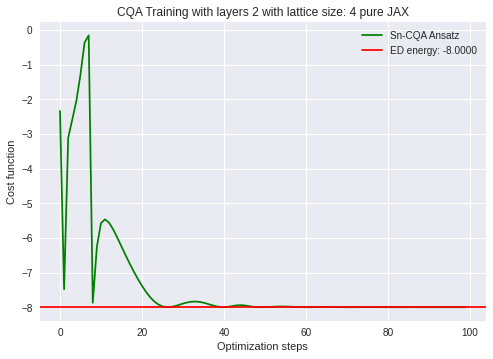

In [23]:
from optimization import CSnGradient


lattice4 =[[(1,2), (1,8), (2,3), (2,7), (3,4), (3,6), (4,5), (5,6), (5, 12),
            (6,7), (6, 11), (7, 10), (7, 8), (8,9), (9, 10), (10, 11), (11, 12)],

           [(1,3), (1,9), (1,7), (2,4), (2,8), (2, 10), (2, 6), (3, 11), (3,5), (3,7),
            (4, 12), (4, 6), (5, 7), (5, 11), (6, 8), (6, 10), (6, 12),  (7, 9), (7, 11), (8, 10),
            (9, 11), (10, 12)]]
lattice_simple = [[(1, 2), (2, 3), (3, 4), (1, 4)]]
# partit = [int(6),int(6)]
# Nsites = int( 12)    

CsnFourier = CSnGradient(J= myargs.J, 
                        lattice = lattice_simple, 
                        Nsites=myargs.num_qubits,
                        partit=[2,2] ,p=myargs.p, num_samples =int(1000), max_iter = int(100), lr=myargs.lr)


# Ham_rep = CsnFourier.Ham_rep()

# print(CsnFilters.rep_mat_H)
# E_gs, V_gs = eigh(Ham_rep.astype('float64'), subset_by_index=[0,1])
# V_gs = V_gs[:,0]
# E_gs = E_gs[0]
# V_gs = jnp.asarray(V_gs)
# print('True Ground state Energy via ED for partition {}:--- ({}) '.format(myargs.irrep, E_gs))
# print('True Ground State wavefuncion in Sn irrep basis for partition {}:--- {}'.format(partit, V_gs))

print('Irrep Dims for {}: --- {}'.format(myargs.irrep, CsnFourier.dim))

print('now the gradient phase')


optimizer = optax.adamw(learning_rate=myargs.lr)
loss_history_jax, param_history_jax =CsnFourier.train(optimizer)
loss_history_jax = [np.array(loss) * 4 for loss in loss_history_jax]
# print(loss_history)
plt.style.use("seaborn")
plt.plot(loss_history_jax , "g", label='Sn-CQA Ansatz')
plt.axhline(e_gs, color='r', linestyle='-', label='ED energy: {:.4f}'.format(e_gs))
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.legend(loc="upper right")
plt.title(f'CQA Training with layers {myargs.p} with lattice size: {myargs.num_qubits} pure JAX') 
plt.show()
# plt.savefig(f'Figures/CQA_p{myargs.p}_lattice{myargs.num_qubits}')  



#### Benchmark with the Hardware efficient ansatz

Use the pennylane's highly entangled layers 

100%|██████████| 100/100 [00:04<00:00, 23.66it/s]


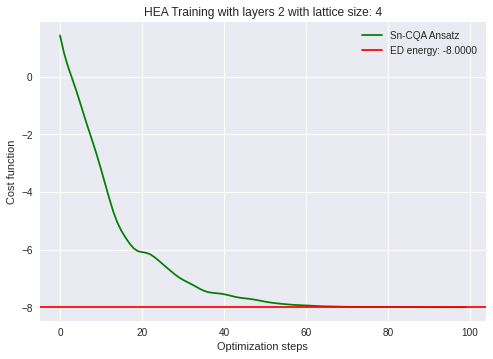

In [24]:
dev = qml.device('default.qubit', wires=myargs.num_qubits)

@qml.qnode(dev, interface='jax')
def circuit_hea(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=[i for i in range(myargs.num_qubits)])
    hamiltonian = getHam_square(myargs.lattice_size, myargs.J)
    return qml.expval(hamiltonian)


optimizer = optax.adamw(learning_rate=myargs.lr)
shape = qml.StronglyEntanglingLayers.shape(n_layers=4, n_wires=myargs.num_qubits)
# weights = np.random.random(size=shape)
key = jax.random.PRNGKey(0)
weights_init = jax.random.uniform(key, shape)
loss_history_hea, grad_history_hea, param_history_hea = [], [], [weights_init]
opt_state = optimizer.init(weights_init)
loss_grad_fn = jax.jit(jax.value_and_grad(circuit_hea))
for it in tqdm(range(1, myargs.iterations + 1)): 
    weights = param_history_hea[-1]
    loss, gradient = loss_grad_fn(weights)
    updates, opt_state = optimizer.update(gradient, opt_state, weights)
    updated_weights = optax.apply_updates(weights, updates)
    param_history_hea.append(updated_weights)
    loss_history_hea.append(loss)
    grad_history_hea.append(gradient)
plt.style.use("seaborn")
plt.plot(loss_history_hea , "g", label='Sn-CQA Ansatz')
plt.axhline(e_gs, color='r', linestyle='-', label='ED energy: {:.4f}'.format(e_gs))
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.legend(loc="upper right")
plt.title(f'HEA Training with layers {myargs.p} with lattice size: {myargs.num_qubits}') 
plt.show()
# plt.savefig(f'Figures/CQA_p{myargs.p}_lattice{myargs.num_qubits}')  
    

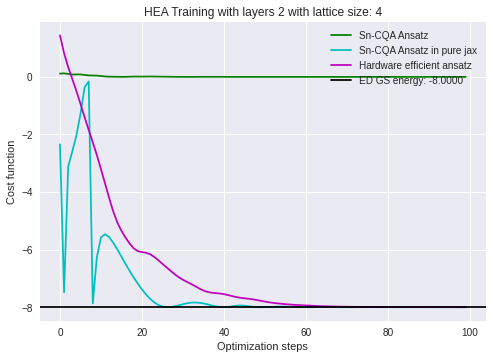

In [27]:
# final comparison with all the methods



plt.style.use("seaborn")
plt.plot(loss_history , "g", label='Sn-CQA Ansatz')
# plt.plot(loss_history_noise , "b", label='Sn-CQA Ansatz with noise')
plt.plot(loss_history_jax , "c", label='Sn-CQA Ansatz in pure jax')
plt.plot(loss_history_hea , "m", label='Hardware efficient ansatz')

plt.axhline(e_gs, color='k', linestyle='-', label='ED GS energy: {:.4f}'.format(e_gs))
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.legend(loc="upper right")
plt.title(f'HEA Training with layers {myargs.p} with lattice size: {myargs.num_qubits}') 
plt.show()